In [1]:
import pandas as pd
import numpy as np
import time
import h5py
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Flatten, GRU,TimeDistributed, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1
import ast
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from scipy.stats import loguniform
# from pandas import read_csv
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from datetime import datetime
from qkeras import *
today = datetime.date(datetime.now())
# from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model

2022-09-09 22:08:16.670800: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-09 22:08:16.677429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 22:08:16.677442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2022-09-09 22:08:25.196997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 22:08:25.197160: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-09 22:08:25.197212: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-CHSBCRQ): /proc/driver/nvidia/version does not exist


In [3]:
#outdir = "/global/homes/e/elham/rnn_hls4ml/results/"
outpath = "gru_training_2022-08-09"
#comd = "mkdir "+outpath
#os.system(comd)

In [4]:
# inputdir = 'rnn_hls4ml_data_scaled'
inputdir = 'rnn_hls4ml_data_scaled_2class'

y-shape:  (379052, 1)
x-shape:  (379052, 20, 6)


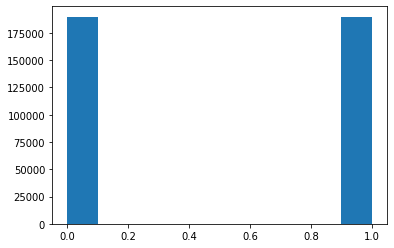

In [3]:
x_train = np.load('./x_train.npy')
y_train = np.load('./y_train.npy')

y_train = y_train[:,4:5]
plt.hist(y_train)

print("y-shape: ", y_train.shape)
print("x-shape: ", x_train.shape)

## Small GRU

In [7]:
model = Sequential()
model.add(GRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
              name = 'layer1', input_shape = (20,6)))
model.add(Dense(5, activation='relu', kernel_initializer='glorot_normal', name='layer2'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))


model.summary()

2022-06-23 10:17:30.501174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 5)                 195       
                                                                 
 layer2 (Dense)              (None, 5)                 30        
                                                                 
 output_sigmoid (Dense)      (None, 1)                 6         
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


## Small QGRU

In [40]:
qmodel = Sequential()
qmodel.add(QGRU(5, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
                name = 'layer1', kernel_quantizer=quantized_bits(2,0,alpha=1),
                recurrent_quantizer=quantized_bits(2,0,alpha=1) , bias_quantizer=quantized_bits(2,0,alpha=1),
                state_quantizer=quantized_bits(2,0,alpha=1) ,input_shape = (20,6)))
qmodel.add(QDense(5, activation='relu', kernel_initializer='glorot_normal', kernel_quantizer=quantized_bits(2,0,alpha=1),
                  bias_quantizer=quantized_bits(2,0,alpha=1), name='layer2'))
qmodel.add(QDense(1, activation='sigmoid', kernel_quantizer=quantized_bits(2,0,alpha=1),
                  bias_quantizer=quantized_bits(2,0,alpha=1), name = 'output_sigmoid'))
qmodel.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 5)                 180       
                                                                 
 layer2 (QDense)             (None, 5)                 30        
                                                                 
 output_sigmoid (QDense)     (None, 1)                 6         
                                                                 
Total params: 216
Trainable params: 216
Non-trainable params: 0
_________________________________________________________________


## GRU

In [12]:
model = Sequential()
model.add(GRU(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001), name = 'layer1', input_shape = (20,6)))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal', name='layer3')) #kernel_regularizer = regularizers.l1_l2(l1= 0.0001, l2 = 0.0001), 
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (GRU)                (None, 20)                1680      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 output_sigmoid (Dense)      (None, 1)                 65        
                                                                 
Total params: 3,089
Trainable params: 3,089
Non-trainable params: 0
_________________________________________________________________


## QGRU

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 20)                1620      
                                                                 
 layer2 (QDense)             (None, 64)                1344      
                                                                 
 output_sigmoid (QDense)     (None, 1)                 65        
                                                                 
Total params: 3,029
Trainable params: 3,029
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1185/1185 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.8092
Epoch 1: val_loss improved from inf to 0.37959, saving model to qgru_2int_trainplot/model_14bits_gru.h5
1185/1185 [==============================] - 54s 40ms/step - loss: 0.4317 - accuracy: 0.8092 - val_loss: 0.3796 -

Epoch 25/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3436 - accuracy: 0.8577
Epoch 25: val_loss did not improve from 0.33804
1185/1185 [==============================] - 86s 72ms/step - loss: 0.3436 - accuracy: 0.8577 - val_loss: 0.3391 - val_accuracy: 0.8608
Epoch 26/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3428 - accuracy: 0.8578
Epoch 26: val_loss improved from 0.33804 to 0.33703, saving model to qgru_2int_trainplot/model_14bits_gru.h5
1185/1185 [==============================] - 86s 72ms/step - loss: 0.3428 - accuracy: 0.8578 - val_loss: 0.3370 - val_accuracy: 0.8618
Epoch 27/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3432 - accuracy: 0.8578
Epoch 27: val_loss improved from 0.33703 to 0.33673, saving model to qgru_2int_trainplot/model_14bits_gru.h5
1185/1185 [==============================] - 84s 71ms/step - loss: 0.3432 - accuracy: 0.8578 - val_loss: 0.3367 - val_accuracy: 0.8604
Epoch 28/150
1185/1185 [=====

1185/1185 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.8623
Epoch 52: val_loss improved from 0.32622 to 0.32342, saving model to qgru_2int_trainplot/model_14bits_gru.h5
1185/1185 [==============================] - 86s 73ms/step - loss: 0.3303 - accuracy: 0.8623 - val_loss: 0.3234 - val_accuracy: 0.8653
Epoch 53/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3301 - accuracy: 0.8624
Epoch 53: val_loss did not improve from 0.32342
1185/1185 [==============================] - 88s 75ms/step - loss: 0.3301 - accuracy: 0.8624 - val_loss: 0.3256 - val_accuracy: 0.8642
Epoch 54/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.8630
Epoch 54: val_loss did not improve from 0.32342
1185/1185 [==============================] - 86s 73ms/step - loss: 0.3286 - accuracy: 0.8630 - val_loss: 0.3248 - val_accuracy: 0.8650
Epoch 55/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8633
Epo

Epoch 79/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8672
Epoch 79: val_loss did not improve from 0.31434
1185/1185 [==============================] - 90s 76ms/step - loss: 0.3193 - accuracy: 0.8672 - val_loss: 0.3155 - val_accuracy: 0.8697
Epoch 80/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8680
Epoch 80: val_loss improved from 0.31434 to 0.31299, saving model to qgru_2int_trainplot/model_14bits_gru.h5
1185/1185 [==============================] - 91s 77ms/step - loss: 0.3180 - accuracy: 0.8680 - val_loss: 0.3130 - val_accuracy: 0.8705
Epoch 81/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8681
Epoch 81: val_loss did not improve from 0.31299
1185/1185 [==============================] - 89s 75ms/step - loss: 0.3178 - accuracy: 0.8681 - val_loss: 0.3134 - val_accuracy: 0.8701
Epoch 82/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3179 - accurac

Epoch 134/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3097 - accuracy: 0.8710
Epoch 134: val_loss did not improve from 0.30604
1185/1185 [==============================] - 93s 78ms/step - loss: 0.3097 - accuracy: 0.8710 - val_loss: 0.3098 - val_accuracy: 0.8708
Epoch 135/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8712
Epoch 135: val_loss improved from 0.30604 to 0.30595, saving model to qgru_2int_trainplot/model_14bits_gru.h5
1185/1185 [==============================] - 93s 79ms/step - loss: 0.3095 - accuracy: 0.8712 - val_loss: 0.3060 - val_accuracy: 0.8738
Epoch 136/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3095 - accuracy: 0.8712
Epoch 136: val_loss did not improve from 0.30595
1185/1185 [==============================] - 93s 79ms/step - loss: 0.3095 - accuracy: 0.8712 - val_loss: 0.3085 - val_accuracy: 0.8720
Epoch 137/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3096 - 

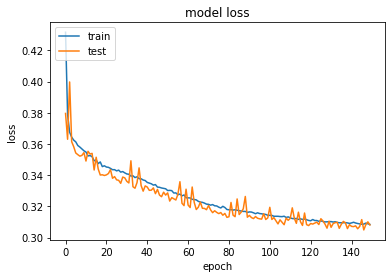

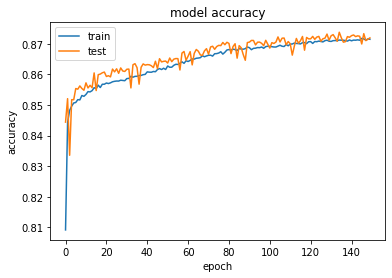

In [54]:
qgru_4int = []
int_bits = 4

for i in [2, 4, 6, 8, 10, 12, 14]:
    qmodel = Sequential()
    qmodel.add(QGRU(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
                    name = 'layer1', kernel_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                    recurrent_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1) , bias_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                    state_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1) ,input_shape = (20,6)))
    # model.add(Flatten(name='layer2'))
    qmodel.add(QDense(64, activation='relu', kernel_initializer='glorot_normal', kernel_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                      bias_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1), name='layer2'))
    qmodel.add(QDense(1, activation='sigmoid', kernel_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                      bias_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1), name = 'output_sigmoid'))

    qmodel.summary()
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=150)
    adam = Adam(lr = 0.0002)
    
    qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
#     model_output = f'qgru_0int/gru_training_2022-08-09model_{i}bits_gru.h5'
#     model.load_model(model_output, custom_objects={'QGRU': QGRU, 'QDense': QDense})
#     y_keras = model.predict(x_test, batch_size=256)
#     roc_score = roc_auc_score(y_test, y_keras)
#     qgru_0int.append(roc_score)
#     print('roc_auc_score: ', roc_score)

    history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                        batch_size = 256,
                        epochs = 150, 
                        validation_split = 0.2, 
                        shuffle = True,
                        callbacks = [ModelCheckpoint(f'qgru_4int_trainplot/model_{i}bits_gru.h5', verbose=1, save_best_only=True), es],
                        use_multiprocessing=True, workers=4)
    
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#     np.savetxt('training_gru.txt', history.history['loss'])
#     np.savetxt('validation_gru.txt', history.history['val_loss'])

## LSTM

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (LSTM)               (None, 20)                2160      
                                                                 
 layer3 (Dense)              (None, 64)                1344      
                                                                 
 output_sigmoid (Dense)      (None, 1)                 65        
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1182/1185 [============================>.] - ETA: 0s - loss: 0.4292 - accuracy: 0.8152
Epoch 1: val_loss improved from inf to 0.38754, saving model to lstm_plottest_fullepoch/model_toptag_lstm.h5
1185/1185 [==============================] - 35s 18ms/step - loss: 0.4291 - accuracy: 0.8152 - val_loss: 0.3

Epoch 52/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3398 - accuracy: 0.8584
Epoch 52: val_loss did not improve from 0.33636
1185/1185 [==============================] - 34s 29ms/step - loss: 0.3398 - accuracy: 0.8584 - val_loss: 0.3374 - val_accuracy: 0.8602
Epoch 53/150
1183/1185 [============================>.] - ETA: 0s - loss: 0.3397 - accuracy: 0.8585
Epoch 53: val_loss improved from 0.33636 to 0.33516, saving model to lstm_plottest_fullepoch/model_toptag_lstm.h5
1185/1185 [==============================] - 34s 29ms/step - loss: 0.3397 - accuracy: 0.8584 - val_loss: 0.3352 - val_accuracy: 0.8617
Epoch 54/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3391 - accuracy: 0.8588
Epoch 54: val_loss did not improve from 0.33516
1185/1185 [==============================] - 34s 29ms/step - loss: 0.3392 - accuracy: 0.8588 - val_loss: 0.3374 - val_accuracy: 0.8601
Epoch 55/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3391 - ac

Epoch 80/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8600
Epoch 80: val_loss did not improve from 0.33176
1185/1185 [==============================] - 37s 31ms/step - loss: 0.3353 - accuracy: 0.8600 - val_loss: 0.3355 - val_accuracy: 0.8613
Epoch 81/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8598
Epoch 81: val_loss improved from 0.33176 to 0.33032, saving model to lstm_plottest_fullepoch/model_toptag_lstm.h5
1185/1185 [==============================] - 36s 31ms/step - loss: 0.3355 - accuracy: 0.8598 - val_loss: 0.3303 - val_accuracy: 0.8629
Epoch 82/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8600
Epoch 82: val_loss did not improve from 0.33032
1185/1185 [==============================] - 37s 31ms/step - loss: 0.3355 - accuracy: 0.8600 - val_loss: 0.3386 - val_accuracy: 0.8603
Epoch 83/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3347 - ac

Epoch 108/150
1182/1185 [============================>.] - ETA: 0s - loss: 0.3324 - accuracy: 0.8618
Epoch 108: val_loss did not improve from 0.32857
1185/1185 [==============================] - 38s 32ms/step - loss: 0.3323 - accuracy: 0.8619 - val_loss: 0.3326 - val_accuracy: 0.8618
Epoch 109/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3325 - accuracy: 0.8614
Epoch 109: val_loss improved from 0.32857 to 0.32670, saving model to lstm_plottest_fullepoch/model_toptag_lstm.h5
1185/1185 [==============================] - 37s 32ms/step - loss: 0.3325 - accuracy: 0.8614 - val_loss: 0.3267 - val_accuracy: 0.8637
Epoch 110/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3322 - accuracy: 0.8614
Epoch 110: val_loss did not improve from 0.32670
1185/1185 [==============================] - 38s 32ms/step - loss: 0.3322 - accuracy: 0.8614 - val_loss: 0.3305 - val_accuracy: 0.8618
Epoch 111/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.33

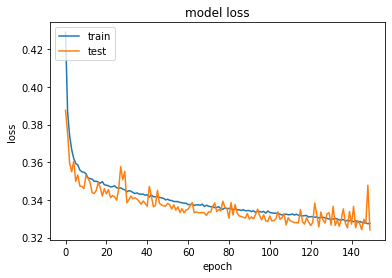

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


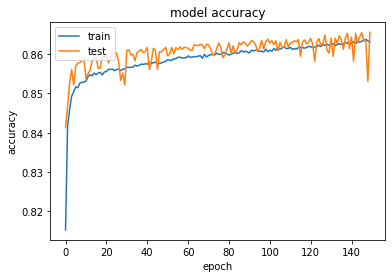

In [56]:
model = Sequential()
model.add(LSTM(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
               name = 'layer1', input_shape = (20,6)))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal', name='layer3'))
model.add(Dense(1, activation='sigmoid', name = 'output_sigmoid'))

model.summary()

es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=150)
adam = Adam(lr = 0.0002)
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 256,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'lstm_plottest_fullepoch/model_toptag_lstm.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)

print(history.history.keys())
    # summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history.history.keys())
    # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## QLSTM

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QLSTM)              (None, 20)                2160      
                                                                 
 layer3 (QDense)             (None, 64)                1344      
                                                                 
 output_sigmoid (QDense)     (None, 1)                 65        
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8336
Epoch 1: val_loss improved from inf to 0.35921, saving model to qlstm_plot2int/model_14bits_lstm.h5
1185/1185 [==============================] - 78s 61ms/step - loss: 0.3967 - accuracy: 0.8336 - val_loss: 0.3592 - val

Epoch 25/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8585
Epoch 25: val_loss did not improve from 0.33282
1185/1185 [==============================] - 119s 100ms/step - loss: 0.3393 - accuracy: 0.8585 - val_loss: 0.3335 - val_accuracy: 0.8615
Epoch 26/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3380 - accuracy: 0.8589
Epoch 26: val_loss did not improve from 0.33282
1185/1185 [==============================] - 120s 101ms/step - loss: 0.3380 - accuracy: 0.8589 - val_loss: 0.3329 - val_accuracy: 0.8623
Epoch 27/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3377 - accuracy: 0.8585
Epoch 27: val_loss did not improve from 0.33282
1185/1185 [==============================] - 118s 100ms/step - loss: 0.3377 - accuracy: 0.8585 - val_loss: 0.3375 - val_accuracy: 0.8612
Epoch 28/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3378 - accuracy: 0.8587
Epoch 28: val_loss improved from 0.33282 to 0

Epoch 53/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.8625
Epoch 53: val_loss did not improve from 0.32303
1185/1185 [==============================] - 117s 98ms/step - loss: 0.3285 - accuracy: 0.8625 - val_loss: 0.3250 - val_accuracy: 0.8644
Epoch 54/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.8629
Epoch 54: val_loss did not improve from 0.32303
1185/1185 [==============================] - 118s 100ms/step - loss: 0.3281 - accuracy: 0.8629 - val_loss: 0.3265 - val_accuracy: 0.8644
Epoch 55/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.8628
Epoch 55: val_loss did not improve from 0.32303
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3283 - accuracy: 0.8628 - val_loss: 0.3237 - val_accuracy: 0.8650
Epoch 56/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3273 - accuracy: 0.8632
Epoch 56: val_loss improved from 0.32303 to 0.3

Epoch 81/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8668
Epoch 81: val_loss did not improve from 0.31690
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3211 - accuracy: 0.8668 - val_loss: 0.3181 - val_accuracy: 0.8679
Epoch 82/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8667
Epoch 82: val_loss did not improve from 0.31690
1185/1185 [==============================] - 115s 97ms/step - loss: 0.3214 - accuracy: 0.8667 - val_loss: 0.3171 - val_accuracy: 0.8681
Epoch 83/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3214 - accuracy: 0.8661
Epoch 83: val_loss did not improve from 0.31690
1185/1185 [==============================] - 116s 98ms/step - loss: 0.3214 - accuracy: 0.8661 - val_loss: 0.3191 - val_accuracy: 0.8681
Epoch 84/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3208 - accuracy: 0.8670
Epoch 84: val_loss improved from 0.31690 to 0.31

Epoch 109/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8682
Epoch 109: val_loss did not improve from 0.31324
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3183 - accuracy: 0.8682 - val_loss: 0.3160 - val_accuracy: 0.8675
Epoch 110/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3181 - accuracy: 0.8681
Epoch 110: val_loss did not improve from 0.31324
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3181 - accuracy: 0.8681 - val_loss: 0.3168 - val_accuracy: 0.8687
Epoch 111/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3180 - accuracy: 0.8681
Epoch 111: val_loss did not improve from 0.31324
1185/1185 [==============================] - 116s 98ms/step - loss: 0.3180 - accuracy: 0.8681 - val_loss: 0.3158 - val_accuracy: 0.8686
Epoch 112/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8680
Epoch 112: val_loss did not improve from 

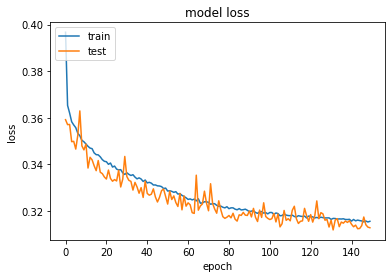

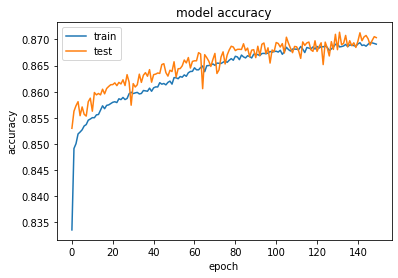

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QLSTM)              (None, 20)                2160      
                                                                 
 layer3 (QDense)             (None, 64)                1344      
                                                                 
 output_sigmoid (QDense)     (None, 1)                 65        
                                                                 
Total params: 3,569
Trainable params: 3,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
1185/1185 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8296
Epoch 1: val_loss improved from inf to 0.41272, saving model to qlstm_plot4int/model_14bits_lstm.h5
1185/1185 [==============================] - 124s 101ms/step - loss: 0.4127 - accuracy: 0.8296 - val_loss: 0.4127 - v

Epoch 25/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3455 - accuracy: 0.8564
Epoch 25: val_loss did not improve from 0.34160
1185/1185 [==============================] - 116s 98ms/step - loss: 0.3455 - accuracy: 0.8564 - val_loss: 0.3451 - val_accuracy: 0.8570
Epoch 26/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3448 - accuracy: 0.8567
Epoch 26: val_loss did not improve from 0.34160
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3448 - accuracy: 0.8567 - val_loss: 0.3468 - val_accuracy: 0.8572
Epoch 27/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8566
Epoch 27: val_loss improved from 0.34160 to 0.34120, saving model to qlstm_plot4int/model_14bits_lstm.h5
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3446 - accuracy: 0.8566 - val_loss: 0.3412 - val_accuracy: 0.8583
Epoch 28/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3435 - accuracy

Epoch 52/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3323 - accuracy: 0.8613
Epoch 52: val_loss did not improve from 0.32790
1185/1185 [==============================] - 122s 103ms/step - loss: 0.3323 - accuracy: 0.8613 - val_loss: 0.3331 - val_accuracy: 0.8627
Epoch 53/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3321 - accuracy: 0.8614
Epoch 53: val_loss did not improve from 0.32790
1185/1185 [==============================] - 121s 102ms/step - loss: 0.3321 - accuracy: 0.8614 - val_loss: 0.3336 - val_accuracy: 0.8623
Epoch 54/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3322 - accuracy: 0.8616
Epoch 54: val_loss improved from 0.32790 to 0.32704, saving model to qlstm_plot4int/model_14bits_lstm.h5
1185/1185 [==============================] - 121s 102ms/step - loss: 0.3322 - accuracy: 0.8616 - val_loss: 0.3270 - val_accuracy: 0.8641
Epoch 55/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3316 - accur

Epoch 80/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8650
Epoch 80: val_loss improved from 0.32001 to 0.31824, saving model to qlstm_plot4int/model_14bits_lstm.h5
1185/1185 [==============================] - 134s 113ms/step - loss: 0.3228 - accuracy: 0.8650 - val_loss: 0.3182 - val_accuracy: 0.8675
Epoch 81/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8651
Epoch 81: val_loss did not improve from 0.31824
1185/1185 [==============================] - 117s 98ms/step - loss: 0.3230 - accuracy: 0.8651 - val_loss: 0.3227 - val_accuracy: 0.8651
Epoch 82/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3231 - accuracy: 0.8652
Epoch 82: val_loss did not improve from 0.31824
1185/1185 [==============================] - 112s 95ms/step - loss: 0.3231 - accuracy: 0.8652 - val_loss: 0.3188 - val_accuracy: 0.8672
Epoch 83/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3225 - accurac

Epoch 108/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3196 - accuracy: 0.8672
Epoch 108: val_loss did not improve from 0.31654
1185/1185 [==============================] - 107s 90ms/step - loss: 0.3196 - accuracy: 0.8672 - val_loss: 0.3243 - val_accuracy: 0.8648
Epoch 109/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.8663
Epoch 109: val_loss did not improve from 0.31654
1185/1185 [==============================] - 105s 89ms/step - loss: 0.3202 - accuracy: 0.8663 - val_loss: 0.3205 - val_accuracy: 0.8665
Epoch 110/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3197 - accuracy: 0.8673
Epoch 110: val_loss did not improve from 0.31654
1185/1185 [==============================] - 105s 89ms/step - loss: 0.3197 - accuracy: 0.8673 - val_loss: 0.3205 - val_accuracy: 0.8654
Epoch 111/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3193 - accuracy: 0.8670
Epoch 111: val_loss did not improve from 

Epoch 136/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8682
Epoch 136: val_loss did not improve from 0.31329
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3168 - accuracy: 0.8682 - val_loss: 0.3143 - val_accuracy: 0.8691
Epoch 137/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8680
Epoch 137: val_loss improved from 0.31329 to 0.31228, saving model to qlstm_plot4int/model_14bits_lstm.h5
1185/1185 [==============================] - 117s 99ms/step - loss: 0.3167 - accuracy: 0.8680 - val_loss: 0.3123 - val_accuracy: 0.8703
Epoch 138/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8682
Epoch 138: val_loss did not improve from 0.31228
1185/1185 [==============================] - 118s 99ms/step - loss: 0.3168 - accuracy: 0.8682 - val_loss: 0.3133 - val_accuracy: 0.8696
Epoch 139/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3166 - a

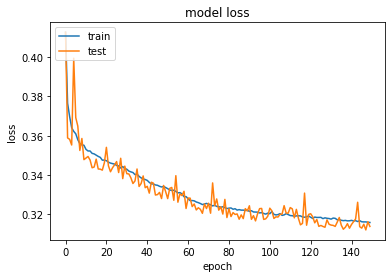

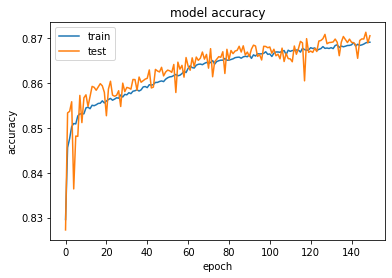

In [55]:


int_bits = 4
for i in [2, 4, 6, 8, 10, 12, 14]:
    qmodel = Sequential()
    qmodel.add(QLSTM(20, kernel_initializer = 'VarianceScaling', kernel_regularizer = regularizers.l1_l2(l1= 0.00001, l2 = 0.0001),
                    name = 'layer1', kernel_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                    recurrent_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1) , bias_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                    state_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1) ,input_shape = (20,6)))
    # model.add(Flatten(name='layer2'))
    qmodel.add(QDense(64, activation='relu', kernel_initializer='glorot_normal', kernel_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                      bias_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1), name='layer3'))
    qmodel.add(QDense(1, activation='sigmoid', kernel_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1),
                      bias_quantizer=quantized_bits(i+int_bits+1,int_bits,alpha=1), name = 'output_sigmoid'))
    qmodel.summary()
    
    es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=150)
    adam = Adam(lr = 0.0002)
    
    qmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = qmodel.fit(x_train.astype('float32'), y_train.astype('float32'), 
                        batch_size = 256,
                        epochs = 150, 
                        validation_split = 0.2, 
                        shuffle = True,
                        callbacks = [ModelCheckpoint(f'qlstm_plot{int_bits}int/model_{i}bits_lstm.h5', verbose=1, save_best_only=True), es],
                        use_multiprocessing=True, workers=4)
    
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Training

In [18]:
es = EarlyStopping(monitor='val_loss',min_delta = 1e-4, mode='min', verbose=1, patience=10)
adam = Adam(lr = 0.0002)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.4361 - accuracy: 0.8033
Epoch 1: val_loss improved from inf to 0.39536, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 88s 23ms/step - loss: 0.4362 - accuracy: 0.8033 - val_loss: 0.3954 - val_accuracy: 0.8366
Epoch 2/150
1183/1185 [============================>.] - ETA: 0s - loss: 0.3854 - accuracy: 0.8410
Epoch 2: val_loss improved from 0.39536 to 0.37787, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 25s 21ms/step - loss: 0.3855 - accuracy: 0.8409 - val_loss: 0.3779 - val_accuracy: 0.8434
Epoch 3/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8431
Epoch 3: val_loss improved from 0.37787 to 0.37415, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 22s 19ms/step - loss: 0.3809 - accuracy: 0.8431 - val_loss: 0.3741 - val_accuracy: 0.8456
Epoch 4/

Epoch 28/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3482 - accuracy: 0.8552
Epoch 28: val_loss improved from 0.34459 to 0.34134, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 40s 34ms/step - loss: 0.3481 - accuracy: 0.8553 - val_loss: 0.3413 - val_accuracy: 0.8600
Epoch 29/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3467 - accuracy: 0.8562
Epoch 29: val_loss improved from 0.34134 to 0.34093, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 36s 31ms/step - loss: 0.3467 - accuracy: 0.8562 - val_loss: 0.3409 - val_accuracy: 0.8595
Epoch 30/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3460 - accuracy: 0.8570
Epoch 30: val_loss did not improve from 0.34093
1185/1185 [==============================] - 39s 33ms/step - loss: 0.3460 - accuracy: 0.8570 - val_loss: 0.3497 - val_accuracy: 0.8578
Epoch 31/150
1184/1185 [=========================

Epoch 55/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8603
Epoch 55: val_loss did not improve from 0.32983
1185/1185 [==============================] - 39s 33ms/step - loss: 0.3365 - accuracy: 0.8603 - val_loss: 0.3396 - val_accuracy: 0.8593
Epoch 56/150
1184/1185 [============================>.] - ETA: 0s - loss: 0.3364 - accuracy: 0.8602
Epoch 56: val_loss improved from 0.32983 to 0.32898, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 37s 32ms/step - loss: 0.3364 - accuracy: 0.8602 - val_loss: 0.3290 - val_accuracy: 0.8637
Epoch 57/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3352 - accuracy: 0.8606
Epoch 57: val_loss did not improve from 0.32898
1185/1185 [==============================] - 38s 32ms/step - loss: 0.3352 - accuracy: 0.8606 - val_loss: 0.3318 - val_accuracy: 0.8635
Epoch 58/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8610


1185/1185 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8681
Epoch 110: val_loss did not improve from 0.31370
1185/1185 [==============================] - 37s 31ms/step - loss: 0.3176 - accuracy: 0.8681 - val_loss: 0.3280 - val_accuracy: 0.8626
Epoch 111/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8683
Epoch 111: val_loss improved from 0.31370 to 0.31278, saving model to gru_float/model_toptag_gru.h5
1185/1185 [==============================] - 38s 32ms/step - loss: 0.3178 - accuracy: 0.8683 - val_loss: 0.3128 - val_accuracy: 0.8703
Epoch 112/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3173 - accuracy: 0.8687
Epoch 112: val_loss did not improve from 0.31278
1185/1185 [==============================] - 37s 31ms/step - loss: 0.3173 - accuracy: 0.8687 - val_loss: 0.3165 - val_accuracy: 0.8697
Epoch 113/150
1185/1185 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8683
Epoch 1

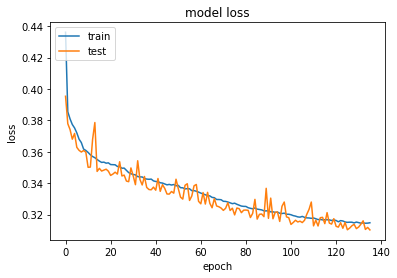

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


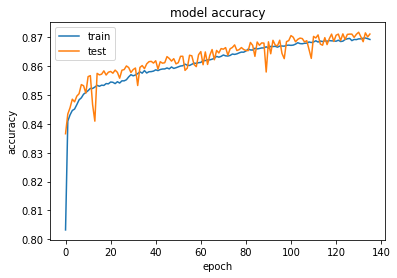

In [20]:
history = model.fit(x_train.astype('float32'), y_train.astype('float32'), 
                    batch_size = 256,
                    epochs = 150, 
                    validation_split = 0.2, 
                    shuffle = True,
                    callbacks = [ModelCheckpoint(f'gru_float/model_toptag_gru.h5', verbose=1, save_best_only=True), es],
                    use_multiprocessing=True, workers=4)

print(history.history.keys())
    # summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(history.history.keys())
    # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#np.savetxt(outpath+'training_gru.txt', history.history['loss'])
#np.savetxt(outpath+'validation_gru.txt', history.history['val_loss'])

## Check GRU Performance

In [16]:
x_test = np.load('./x_test.npy')
y_test = np.load('./y_test.npy')

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


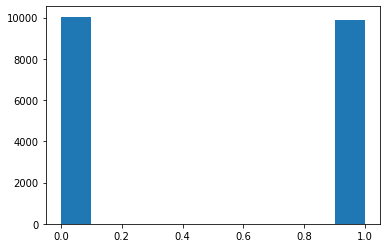

In [12]:
plt.hist(y_test)
plt.savefig('%s/y_test.png'%(outpath))

In [22]:
int_bits = 4
auc_4int = []
for i in [2, 4, 6, 8, 10, 12, 14]:
    qgru_model = load_model(f"qgru_{int_bits}int/model_{i}bits_gru.h5", custom_objects={'QGRU': QGRU, 'QDense': QDense})
    print(qgru_model.summary())
    labels = ['j_t']
    y_keras = qgru_model.predict(x_test)
    auc_score = roc_auc_score(y_test, y_keras)
    auc_4int.append(auc_score)
    print(auc_score)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 20)                1620      
                                                                 
 layer2 (QDense)             (None, 64)                1344      
                                                                 
 output_sigmoid (QDense)     (None, 1)                 65        
                                                                 
Total params: 3,029
Trainable params: 3,029
Non-trainable params: 0
_________________________________________________________________
None
624/624 [==============================] - 11s 17ms/step
0.915384481492295
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (QGRU)               (None, 20)                1620      
                

### Plot GRU

In [19]:
print(auc_0int)

[0.8205885373157944, 0.916493511118958, 0.9300590322737419, 0.9242811492157833, 0.9385474378064065, 0.9369371565354694, 0.9368631961028887]


In [21]:
print(auc_2int)

[0.9131254648718948, 0.9350201095597259, 0.9376546616709431, 0.9391647076875074, 0.9378134964609336, 0.9387795546772961, 0.9359261663136627]


In [33]:
print(auc_4int)

[0.915384481492295, 0.9302582666749799, 0.9366935880832324, 0.9372243857118514, 0.9408127053119297, 0.9373483180516275, 0.9407559147141292]


In [26]:
gru_model = load_model("gru_float/model_toptag_gru.h5")
labels = ['j_t']
y_keras = gru_model.predict(x_test)
auc_score = roc_auc_score(y_test, y_keras)
print(auc_score)
#y_pred = makeRoc(x_test, y_test, labels, qgru_model, outputDir=outpath,outputSuffix='qgru')

gru_float = []
for i in range(7):
    gru_float.append(auc_score)

624/624 [==============================] - 9s 14ms/step
0.9403262568087918


In [47]:
ratio_0int_qgru = []
for i in range(7):
    ratio_0int_qgru.append(auc_0int[i]/gru_float[i])
print(ratio_0int_qgru)

[0.8726636434684338, 0.974654812074784, 0.9890812104195685, 0.9829366589767884, 0.998108295935049, 0.9963958251205023, 0.9963171711086153]


In [8]:
ratio_0int_qgru = [0.8726636434684338, 0.974654812074784, 0.9890812104195685, 0.9829366589767884, 0.998108295935049, 0.9963958251205023, 0.9963171711086153]

In [46]:
ratio_2int_qgru = []
for i in range(7):
    ratio_2int_qgru.append(auc_2int[i]/gru_float[i])
print(ratio_2int_qgru)

[0.9710730273243576, 0.9943571210410805, 0.9971588636194045, 0.998764738182228, 0.997327778173093, 0.9983551431002844, 0.9953206767722707]


In [9]:
ratio_2int_qgru = [0.9710730273243576, 0.9943571210410805, 0.9971588636194045, 0.998764738182228, 0.997327778173093, 0.9983551431002844, 0.9953206767722707]

In [48]:
ratio_4int_qgru = []
for i in range(7):
    ratio_4int_qgru.append(auc_4int[i]/gru_float[i])
print(ratio_4int_qgru)

[0.973475402674448, 0.9892930883712853, 0.9961367996487861, 0.9967012820555843, 1.0005173188556797, 0.9968330792258524, 1.0004569242879546]


In [10]:
ratio_4int_qgru = [0.973475402674448, 0.9892930883712853, 0.9961367996487861, 0.9967012820555843, 1.0005173188556797, 0.9968330792258524, 1.0004569242879546]

## Check LSTM Performance

In [59]:
int_bits = 4
lstm_4int = []
for i in [2, 4, 6, 8, 10, 12, 14]:
    qlstm_model = load_model(f"qlstm_{int_bits}int/model_{i}bits_lstm.h5", custom_objects={'QLSTM': QLSTM, 'QDense': QDense})
    #print(qlstm_model.summary())
    labels = ['j_t']
    y_keras = qlstm_model.predict(x_test)
    auc_score = roc_auc_score(y_test, y_keras)
    lstm_4int.append(auc_score)
    print(auc_score)

624/624 [==============================] - 12s 18ms/step
0.9142053856741852
624/624 [==============================] - 12s 19ms/step
0.9237978563041704
624/624 [==============================] - 12s 18ms/step
0.9300979998092174
624/624 [==============================] - 12s 18ms/step
0.9371523698874242
624/624 [==============================] - 12s 19ms/step
0.9397904795763484
624/624 [==============================] - 12s 19ms/step
0.928759616966663
624/624 [==============================] - 12s 18ms/step
0.9389827184934587


### Plot LSTM

In [56]:
print(lstm_0int)

[0.853992739807972, 0.9120670553551454, 0.9265185892278878, 0.931105055591272, 0.9358997658711884, 0.9358205745934199, 0.9367758595801166]


In [58]:
print(lstm_2int)

[0.9127005102048815, 0.928903322001745, 0.9362891598356149, 0.9373131342110862, 0.9423726126894898, 0.9371698211125313, 0.9367616845423891]


In [60]:
print(lstm_4int)

[0.9142053856741852, 0.9237978563041704, 0.9300979998092174, 0.9371523698874242, 0.9397904795763484, 0.928759616966663, 0.9389827184934587]


In [61]:
lstm_model = load_model("lstm_float/model_toptag_lstm.h5")
labels = ['j_t']
y_keras = lstm_model.predict(x_test)
lstm_score = roc_auc_score(y_test, y_keras)
print(lstm_score)

624/624 [==============================] - 8s 12ms/step
0.9310019762846644


In [62]:
ratio_0int_qlstm = []
for i in range(7):
    ratio_0int_qlstm.append(lstm_0int[i]/lstm_score)
print(ratio_0int_qlstm)

[0.917283487641979, 0.9796617822390858, 0.9951843420626577, 1.0001107186764726, 1.005260772491665, 1.005175712223496, 1.0062017948860795]


In [11]:
ratio_0int_qlstm = [0.917283487641979, 0.9796617822390858, 0.9951843420626577, 1.0001107186764726, 1.005260772491665, 1.005175712223496, 1.0062017948860795]

In [63]:
ratio_2int_qlstm = []
for i in range(7):
    ratio_2int_qlstm.append(lstm_2int[i]/lstm_score)
print(ratio_2int_qlstm)

[0.9803421834260564, 0.9977458111407083, 1.0056790250564773, 1.0067788877866914, 1.0122133321888338, 1.0066249535285423, 1.0061865693139662]


In [12]:
ratio_2int_qlstm = [0.9803421834260564, 0.9977458111407083, 1.0056790250564773, 1.0067788877866914, 1.0122133321888338, 1.0066249535285423, 1.0061865693139662]

In [64]:
ratio_4int_qlstm = []
for i in range(7):
    ratio_4int_qlstm.append(lstm_4int[i]/lstm_score)
print(ratio_4int_qlstm)

[0.9819585875880639, 0.9922619713341068, 0.9990290284032967, 1.0066062089656396, 1.009439833121253, 0.9975914558989982, 1.0085722075914842]


In [14]:
ratio_4int_qlstm = [0.9819585875880639, 0.9922619713341068, 0.9990290284032967, 1.0066062089656396, 1.009439833121253, 0.9975914558989982, 1.0085722075914842]

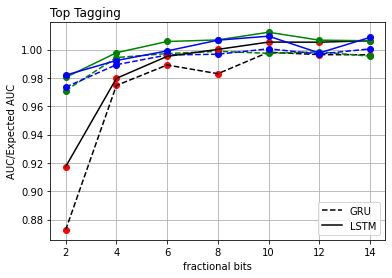

In [43]:
x = [2, 4, 6, 8, 10, 12, 14]
l1 = plt.plot(x, ratio_0int_qgru, "ro")
l2 = plt.plot(x, ratio_0int_qgru, "k--", label="GRU")
l3 = plt.plot(x, ratio_2int_qgru, "go")
l4 = plt.plot(x, ratio_2int_qgru, "g--")
l5 = plt.plot(x, ratio_4int_qgru, "bo")
l6 = plt.plot(x, ratio_4int_qgru, "b--")
l7 = plt.plot(x, ratio_0int_qlstm, "ro")
l8 = plt.plot(x, ratio_0int_qlstm, "k-", label="LSTM")
l9 = plt.plot(x, ratio_2int_qlstm, "go")
l10 = plt.plot(x, ratio_2int_qlstm, "g-")
l11 = plt.plot(x, ratio_4int_qlstm, "bo")
l12 = plt.plot(x, ratio_4int_qlstm, "b-")
plot_lines = []
#plot_lines.append([l1,l3,l5])
plt.xlabel("fractional bits")
plt.ylabel("AUC/Expected AUC")
plt.legend(loc=4)
#plt.ylim([0.0, 1.1])
plt.title("Top Tagging", loc = "left")
plt.grid()